<a href="https://colab.research.google.com/github/ShangWeiKuo/Portfolio/blob/main/Python/Classification/Binary/Casting_binary_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tf_keras_vis

     |████████████████████████████████| 53 kB 1.3 MB/s 


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import cv2
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Activation, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras.applications import imagenet_utils
from keras.preprocessing.image import ImageDataGenerator
from tf_keras_vis.gradcam import Gradcam, GradcamPlusPlus
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize
from tqdm import tqdm

In [3]:
train_path = '/content/drive/MyDrive/Anomaly detection/casting_data/train'
test_path = '/content/drive/MyDrive/Anomaly detection/casting_data/test'

In [4]:
BATCH_SIZE = 32

In [5]:
train = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                             shear_range=0.2, 
                             zoom_range=0.2, 
                             horizontal_flip=True, 
                             vertical_flip=True, 
                             validation_split=0.3)

test = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

training_set = train.flow_from_directory(train_path, 
                      target_size=(224, 224), 
                      class_mode = 'binary', 
                      classes=['ok_front', 'def_front'], 
                      shuffle=True, 
                      batch_size=BATCH_SIZE,
                      color_mode="grayscale",
                      subset='training')

val_set = train.flow_from_directory(train_path, 
                   target_size=(224, 224), 
                   class_mode = 'binary', 
                   classes=['ok_front', 'def_front'], 
                   shuffle=True, 
                   batch_size=BATCH_SIZE,
                   color_mode="grayscale",
                   subset='validation')

test_set = test.flow_from_directory(test_path, 
                   target_size=(224, 224), 
                   class_mode = 'binary', 
                   classes=['ok_front', 'def_front'], 
                   shuffle=True, 
                   batch_size=BATCH_SIZE,
                   color_mode="grayscale")

Found 4644 images belonging to 2 classes.
Found 1989 images belonging to 2 classes.
Found 715 images belonging to 2 classes.


In [6]:
### batch-size = 32
### range的部分要除以batch否則後面的grad-cam會出現格式錯誤的訊息
### 取得test資料的圖片內容與標籤
test_set.reset()
X_test, y_test = next(test_set)
for i in tqdm(range((test_set.n//BATCH_SIZE)-1)): #1st batch is alread fetched before the for loop
  img, label = next(test_set)
  X_test = np.append(X_test, img, axis=0)
  y_test = np.append(y_test, label, axis=0)
print(X_test.shape, y_test.shape)

100%|██████████| 21/21 [06:33<00:00, 18.72s/it]

(704, 224, 224, 1) (704,)


In [7]:
training_set.class_indices

{'def_front': 1, 'ok_front': 0}

In [8]:
def_idx = np.where(y_test == 1)
ok_idx = np.where(y_test == 0)

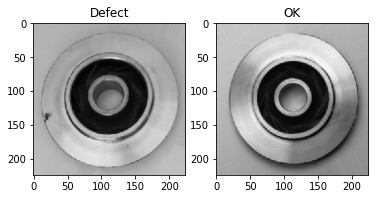

In [9]:
pic1 = plt.subplot(1, 2, 1)
pic1.imshow(X_test[def_idx][0].reshape((X_test.shape[1], X_test.shape[2])), cmap="gray")
pic1.set_title("Defect")
pic2 = plt.subplot(1, 2, 2)
pic2.imshow(X_test[ok_idx][0].reshape((X_test.shape[1], X_test.shape[2])), cmap="gray")
pic2.set_title("OK")
plt.show()

In [10]:
def recall_m(y_true, y_pred):
  TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) # True-Positive
  PP = K.sum(K.round(K.clip(y_true, 0, 1))) # Possible positives
  recall = TP / (PP + K.epsilon())
  return recall

In [11]:
def precision_m(y_true, y_pred):
  TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) # True-Positive
  PP = K.sum(K.round(K.clip(y_pred, 0, 1))) # Predicted positives
  precision = TP / (PP + K.epsilon())
  return precision

In [12]:
def f1_m(y_true, y_pred):
  recall = recall_m(y_true, y_pred)
  precision = precision_m(y_true, y_pred)
  return 2*((precision*recall) / (precision+recall+K.epsilon()))

In [13]:
def create_model():

  input_shape = (224,224) + (1, )
  input = Input(input_shape, name='input')
  layer = Conv2D(8, (3,3), activation='relu', padding='same')(input)
  layer = BatchNormalization()(layer)
  layer = MaxPooling2D(pool_size=(2,2), strides=2)(layer)

  # Add a second layer
  layer = Conv2D(8, (3,3), activation='relu', padding='same')(layer)
  layer = BatchNormalization()(layer)
  layer = MaxPooling2D(pool_size=(2,2), strides=2)(layer)

  # Add a third layer
  layer = Conv2D(16, (3,3), activation='relu', padding='same')(layer)
  layer = BatchNormalization()(layer)
  layer = MaxPooling2D(pool_size=(2,2), strides=2)(layer)

  # Flattening
  layer = Flatten(name='flatten')(layer)

  # Add a second hidden layer
  layer = Dense(128, activation='relu')(layer)

  # Add a third hidden layer
  layer = Dense(64, activation='relu')(layer)

  output = Dense(1, activation='sigmoid')(layer)

  model = Model(inputs=[input], outputs=[output])

  return model

In [14]:
es = EarlyStopping(monitor='val_loss', verbose=2, patience=10,  restore_best_weights=True)

In [15]:
model = create_model()
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001, decay=1e-6), loss='binary_crossentropy', metrics=['accuracy', f1_m, precision_m, recall_m])
History = model.fit_generator(training_set, steps_per_epoch=training_set.n//BATCH_SIZE, validation_data=val_set, validation_steps=val_set.n//BATCH_SIZE, epochs=30, verbose=2, workers=8, callbacks=[es])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
145/145 - 555s - loss: 0.4057 - accuracy: 0.8185 - f1_m: 0.8348 - precision_m: 0.8410 - recall_m: 0.8493 - val_loss: 0.6651 - val_accuracy: 0.5842 - val_f1_m: 0.7274 - val_precision_m: 0.5777 - val_recall_m: 0.9954
Epoch 2/30
145/145 - 34s - loss: 0.2525 - accuracy: 0.8994 - f1_m: 0.9077 - precision_m: 0.9211 - recall_m: 0.9034 - val_loss: 0.7886 - val_accuracy: 0.5670 - val_f1_m: 0.7196 - val_precision_m: 0.5670 - val_recall_m: 1.0000
Epoch 3/30
145/145 - 34s - loss: 0.2101 - accuracy: 0.9141 - f1_m: 0.9228 - precision_m: 0.9357 - recall_m: 0.9187 - val_loss: 0.6266 - val_accuracy: 0.6195 - val_f1_m: 0.7438 - val_precision_m: 0.5989 - val_recall_m: 0.9906
Epoch 4/30
145/145 - 34s - loss: 0.1611 - accuracy: 0.9395 - f1_m: 0.9460 - precision_m: 0.9573 - recall_m: 0.9395 - val_loss: 0.5600 - val_accuracy: 0.6855 - val_f1_m: 0.7784 - val_precision_m: 0.6460 - val_recall_m: 0.9906
Epoch 5/30
145/145 - 33s - loss: 0.1372 - accuracy: 0.9456 - f1_m: 0.9501 - precision_m: 0.9581 - r

In [16]:
# Evaluation 1 - Training data
scores_train = model.evaluate(training_set, steps=training_set.n//BATCH_SIZE)
print("Accuracy: ", round(scores_train[1], 3))
print("F1-Score: ", round(scores_train[2], 3))
print("Precision: ", round(scores_train[3], 3))
print("Recall: ", round(scores_train[4], 3))

145/145 [==============================] - 33s 226ms/step - loss: 0.0190 - accuracy: 0.9946 - f1_m: 0.9953 - precision_m: 0.9967 - recall_m: 0.9941
Accuracy:  0.995
F1-Score:  0.995
Precision:  0.997
Recall:  0.994


In [17]:
# Evaluation 2 - Validataion data
scores_val = model.evaluate(test_set, steps=test_set.n//BATCH_SIZE)
print("Accuracy: ", round(scores_val[1], 3))
print("F1-Score: ", round(scores_val[2], 3))
print("Precision: ", round(scores_val[3], 3))
print("Recall: ", round(scores_val[4], 3))

22/22 [==============================] - 3s 118ms/step - loss: 0.0631 - accuracy: 0.9801 - f1_m: 0.9832 - precision_m: 1.0000 - recall_m: 0.9674
Accuracy:  0.98
F1-Score:  0.983
Precision:  1.0
Recall:  0.967


In [18]:
# Evaluation 3 - Testing data
scores_test = model.evaluate(test_set, steps=test_set.n//BATCH_SIZE)
print("Accuracy: ", round(scores_test[1], 3))
print("F1-Score: ", round(scores_test[2], 3))
print("Precision: ", round(scores_test[3], 3))
print("Recall: ", round(scores_test[4], 3))

22/22 [==============================] - 3s 120ms/step - loss: 0.0631 - accuracy: 0.9801 - f1_m: 0.9831 - precision_m: 1.0000 - recall_m: 0.9673
Accuracy:  0.98
F1-Score:  0.983
Precision:  1.0
Recall:  0.967


In [20]:
# Evaluation - Overview
eval_df = np.array(
            [
              [round(scores_train[1], 3), round(scores_val[1], 3), round(scores_test[1], 3)], 
              [round(scores_train[2], 3), round(scores_val[2], 3), round(scores_test[2], 3)],
              [round(scores_train[3], 3), round(scores_val[3], 3), round(scores_test[3], 3)],
              [round(scores_train[4], 3), round(scores_val[4], 3), round(scores_test[4], 3)]
            ]
          )

eval_df = pd.DataFrame(eval_df, columns=['Train', 'Validation', 'Test'])
rowname = np.array(['Accuracy', 'F1-Score', 'Precision', 'Recall'])
eval_df.index = rowname
eval_df

,Train,Validation,Test
Accuracy,0.995,0.980,0.980
F1-Score,0.995,0.983,0.983
Precision,0.997,1.000,1.000
Recall,0.994,0.967,0.967


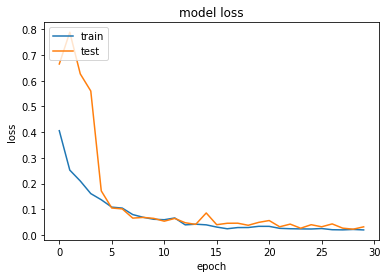

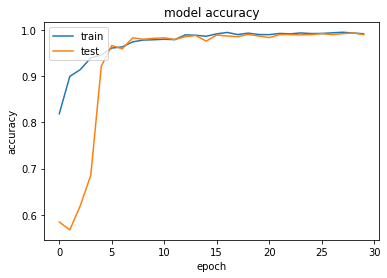

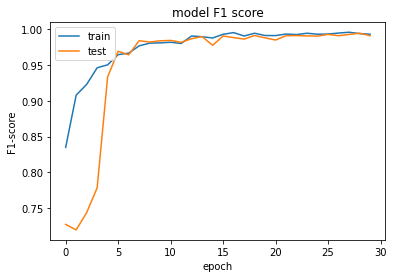

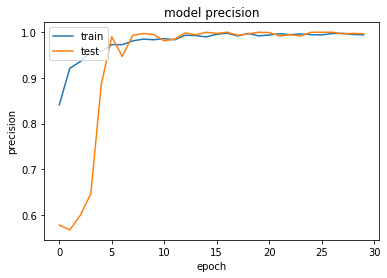

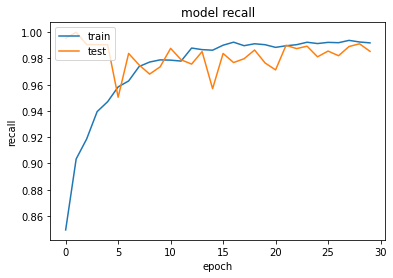

In [21]:
# Loss plot
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Accuracy plot 
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# F1-score plot
plt.plot(History.history['f1_m'])
plt.plot(History.history['val_f1_m'])
plt.title('model F1 score')
plt.ylabel('F1-score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Precision plot
plt.plot(History.history['precision_m'])
plt.plot(History.history['val_precision_m'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Recall plot
plt.plot(History.history['recall_m'])
plt.plot(History.history['val_recall_m'])
plt.title('model recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [22]:
model.save("casting_model.h5")

In [23]:
def Grad_CAM_savepictures(file_index, model):

  def loss(output):
    L = y_test[file_index].astype(np.uint8)
    return (output[0][L-1])
    
  def model_modifier(m):
    m.layers[-1].activation = tf.keras.activations.linear
    return m

  # Create Gradcam object
  gradcam = Gradcam(model, model_modifier=model_modifier, clone=False)
  originalimage = X_test[file_index][:,:,0]
  originalimage = originalimage.reshape((1, originalimage.shape[0], originalimage.shape[1],1))

  # Generate heatmap with GradCAM
  cam = gradcam(loss, originalimage, penultimate_layer=-1)
  cam = normalize(cam)

  #overlap image
  ax1 = plt.subplot(1, 2, 1)
  heatmap = np.uint8(cm.jet(cam)[..., :3] * 255)
  ax1.imshow(X_test[file_index].reshape((X_test.shape[1], X_test.shape[2])),cmap="gray")
  ax1.imshow(heatmap.reshape((X_test.shape[1], X_test.shape[2], 3)), cmap='jet', alpha=0.4) # overlay
  ax1.set_title("Grad-CAM")

  gradcam = GradcamPlusPlus(model, model_modifier=model_modifier, clone=False)
  cam = gradcam(loss, originalimage, penultimate_layer=-1)
  cam = normalize(cam)

  ax1 = plt.subplot(1, 2, 2)
  heatmap = np.uint8(cm.jet(cam)[..., :3] * 255)
  ax1.imshow(X_test[file_index].reshape((X_test.shape[1],X_test.shape[2])), cmap="gray")
  ax1.imshow(heatmap.reshape((X_test.shape[1], X_test.shape[2], 3)), cmap='jet', alpha=0.4) # overlay
  ax1.set_title("Grad-CAM++")

  plt.show()

In [24]:
def_pic = def_idx[0][0]
ok_pic = ok_idx[0][0]

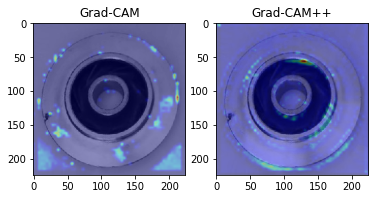

In [25]:
# Defect Grad-CAM & Grad-CAM++
Grad_CAM_savepictures(def_pic, model)

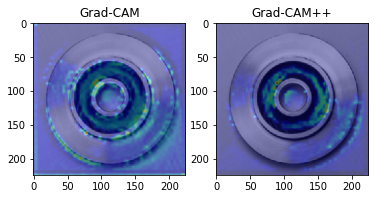

In [26]:
# OK Grad-CAM & Grad-CAM++
Grad_CAM_savepictures(ok_pic, model)